# Road to the Top series

References:
1. [Practical deep learning for coders - Lesson 6](https://course.fast.ai/Lessons/lesson6.html)
2. [Part 1 - Kaggle notebook](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1)


Major difference between this notebook and the reference one:

1. Using PyTorch (instead of FastAI) to create the models



## Prep

In [85]:
!pip install timm

In [86]:
!pip install torchinfo

In [87]:
import os
import tensorflow as tf
import zipfile as zp
import matplotlib.pyplot as plt
from google.colab import userdata
import shutil
from PIL import Image
from fastai.vision.all import *
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2 as transforms
import torch
import timm
from tempfile import TemporaryDirectory
import time

os.environ['KAGGLE_USERNAME'] = 'kevvo83'
os.environ['KAGGLE_KEY'] =  userdata.get('KAGGLE_KEY') # Add the KAGGLE_KEY secret to google colab secrets

## Data download

In [88]:
# First manually accepted the competition rules at https://www.kaggle.com/competitions/paddy-disease-classification/rules

!kaggle competitions download -c paddy-disease-classification

paddy-disease-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [89]:
zipfile = '/content/paddy-disease-classification.zip'
path = '/content/paddy-disease-classification'

if os.path.exists(path):
  shutil.rmtree(path, ignore_errors=True, onerror=None)

zp.ZipFile(f'{zipfile}').extractall(path)

## Data pre-processing

### Check image sizes for consistency



In [12]:
from fastai.vision.all import *
from fastcore.parallel import *

train_val_files = [filename for filename in glob.iglob(os.path.join(path, 'train_images') + '**/**', recursive=True) if not os.path.isdir(filename)]

def f(o): return PILImage.create(o).size
sizes = parallel(f, train_val_files, n_workers=8)
pd.Series(sizes).value_counts()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(480, 640)    10403
(640, 480)        4
Name: count, dtype: int64

### REDUNDANT - Create training/validation split datasets (in TF)

As there are some images that are not the same size, we will resize all images to the smallest image size dimension - i.e. 480.

#### Create batched datasets

In [19]:
batch_size = 32
original_img_size = (480, 640)
original_img_size_with_rgb = original_img_size + (3,)
resized_img_size = (480,480)
resized_img_size_with_rgb = resized_img_size + (3,)

In [14]:
# Note - Tensorflow's ImageDataGenerator has been deprecated and is replaced by
#     Keras' image_dataset_from_directory()

(train_data_ds, val_data_ds) = tf.keras.utils.image_dataset_from_directory(
    os.path.join(path, 'train_images'),
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=resized_img_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 10407 files belonging to 10 classes.
Using 8326 files for training.
Using 2081 files for validation.


#### Show some training images - TOBEFIXED

**TODO: Could not get these to work for some reason...**

In [11]:
# plt.figure(figsize=(10, 10))
if False:
  for images_in_batch, labels_in_batch in train_data_ds.take(1):
    for i in range(0, 2):
      Image.fromarray(images_in_batch[i].numpy(), mode="RGB").show(title=labels_in_batch[i])#
      # ax = plt.subplot(3, 3, i + 1)
      # plt.imshow(images_in_batch[i].numpy().astype("uint64"))
      # plt.title(labels_in_batch[i])
      # plt.axis("off")

In [22]:
if False:
  dir = os.path.join(path, 'train_images', 'bacterial_leaf_blight')
  for filename in os.listdir(dir)[0:2]:
    with Image.open(os.path.join(dir, filename)) as im:
      print(filename)
      print(im.size)
      im.thumbnail(size=(480//4,640//4))

103355.jpg
(480, 640)
106916.jpg
(480, 640)


### REDUNDANT - Create training/validation split datasets (in FastAI)

Will continue with workbook using PyTorch:
* More pre-trained models available in `timm` than anywhere else
* As far as I know, I can't directly use these models in TF
  * Will investigate further into this - but for now, just switching to PyTorch

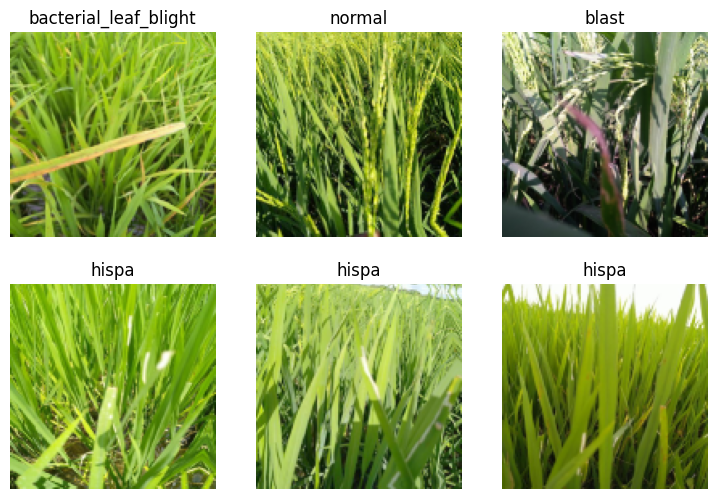

In [5]:
# fastai' ImageDataLoaders
dls = ImageDataLoaders.from_folder(
    os.path.join(path, 'train_images'),
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75),
    bs=64,
    shuffle=True
  )

dls.show_batch(max_n=6)

### Create Image Augmented training/validation split datasets in vanilla PyTorch

Both Training and Validation datasets have the same data tranformations applied to them

In [133]:
data_transforms = transforms.Compose([
    transforms.Resize(size=(480, 480)), # resize all images to the same size - as 4 of them are not the same size
    transforms.RandomResize(128, 160),
    transforms.RandomCrop((128, 128)),
    # transforms.RandomResizedCrop(size=(128, 128), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(), # might need to normalize post this
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_val_ds = ImageFolder(
                  root=os.path.join(path, 'train_images'),
                  transform=data_transforms
                )

val_split = 0.2
size_ds = len(train_val_ds.samples)
size_val_ds   = int(size_ds * val_split)
size_train_ds = size_ds - size_val_ds

print(f'Splitting dataset of size {size_ds} into train set of size {size_train_ds} and val set of size {size_val_ds}')

train_ds, val_ds = torch.utils.data.random_split(train_val_ds, [size_train_ds, size_val_ds])

# train_ds and val_ds are of type Subset(dataset, indices)
#   * if you do train_ds.dataset you get the full ImageFolder dataset back
#   * if you do train_ds.indices you get the indices of the full dataset used to make the train ds

batch_size = 64

train_dl = DataLoader(train_ds.dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds.dataset, batch_size=batch_size, shuffle=True)

Splitting dataset of size 10407 into train set of size 8326 and val set of size 2081


In [44]:
train_val_ds.transform

Compose(
      Resize(size=[480, 480], interpolation=InterpolationMode.BILINEAR, antialias=True)
      RandomResize(min_size=128, max_size=160, interpolation=InterpolationMode.BILINEAR, antialias=True)
      RandomCrop(size=(128, 128), pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
)

In [29]:
print(val_ds.dataset.__len__()) # matrix of images
print(val_ds.dataset[0][0].shape) # each image
print(val_ds.dataset[0][1]) # label

10407
torch.Size([3, 128, 128])
0


In [33]:
print(len(train_ds.dataset.classes))
print(len(val_ds.dataset.classes))

print(val_ds.dataset.__len__())

for image, label in train_dl:
  print(image.shape)
  print(label.shape)
  break

train_dl.dataset.__len__()

10
10
10407
torch.Size([64, 3, 160, 160])
torch.Size([64])


10407

## Step 0 - Done in FastAI - model performance used as a baseline

In [6]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

In [7]:
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.753284,1.198555,0.378184,01:39


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,error_rate,time
0,1.143375,0.773949,0.244113,01:37
1,0.774320,0.546665,0.163383,01:35
2,0.545887,0.457653,0.139356,01:42


## Step 1 - Feature learning on the `resnet26d` pre-trained model


### Import pre-trained model for fine-tuning

In [134]:
device = torch.device('cuda')

In [135]:
model = timm.create_model('resnet26d', pretrained=True)
print(type(model))

import torchinfo
torchinfo.summary(model,
                  input_size=(5, 3, 128, 128),
                  verbose=0,
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"]
                ) # What the pre-trained model looks like

<class 'timm.models.resnet.ResNet'>


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [5, 3, 128, 128]     [5, 1000]            --                   True
├─Sequential (conv1)                     [5, 3, 128, 128]     [5, 64, 64, 64]      --                   True
│    └─Conv2d (0)                        [5, 3, 128, 128]     [5, 32, 64, 64]      864                  True
│    └─BatchNorm2d (1)                   [5, 32, 64, 64]      [5, 32, 64, 64]      64                   True
│    └─ReLU (2)                          [5, 32, 64, 64]      [5, 32, 64, 64]      --                   --
│    └─Conv2d (3)                        [5, 32, 64, 64]      [5, 32, 64, 64]      9,216                True
│    └─BatchNorm2d (4)                   [5, 32, 64, 64]      [5, 32, 64, 64]      64                   True
│    └─ReLU (5)                          [5, 32, 64, 64]      [5, 32, 64, 64]      --                   --
│    └─Conv2d (6) 

### Freeze all weights apart from final connected layer

In [136]:
for param in model.parameters():
    param.requires_grad = False

num_input_features_to_final_fully_connected_layer = model.fc.in_features
num_output_classes = len(train_ds.dataset.classes)

# TODO: Assess whether the single Linear layer below will create the probabilities that I want (from Softmax)
#  model.fc = nn.Sequential(
#      nn.Linear(in_features=num_input_features_to_final_fully_connected_layer,
#                out_features=num_output_classes,
#                device=device)
# )

model.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(
                in_features=num_input_features_to_final_fully_connected_layer,
                out_features=num_output_classes,
                device=device
            )
          )

model = model.to(device)
criterion = nn.CrossEntropyLoss()

from torch import optim
from torch.optim import lr_scheduler

optimizer = optim.Adam(model.fc.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [14]:
train_ds.dataset.classes

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [52]:
# model # What the model looks like after the fc (i.e. final connected layer is updated)

torchinfo.summary(model,
                  input_size=(5, 3, 128, 128),
                  verbose=0,
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"]
                ) # What the pre-trained model looks like after the fc layer is replace

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [5, 3, 128, 128]     [5, 10]              --                   Partial
├─Sequential (conv1)                     [5, 3, 128, 128]     [5, 64, 64, 64]      --                   False
│    └─Conv2d (0)                        [5, 3, 128, 128]     [5, 32, 64, 64]      (864)                False
│    └─BatchNorm2d (1)                   [5, 32, 64, 64]      [5, 32, 64, 64]      (64)                 False
│    └─ReLU (2)                          [5, 32, 64, 64]      [5, 32, 64, 64]      --                   --
│    └─Conv2d (3)                        [5, 32, 64, 64]      [5, 32, 64, 64]      (9,216)              False
│    └─BatchNorm2d (4)                   [5, 32, 64, 64]      [5, 32, 64, 64]      (64)                 False
│    └─ReLU (5)                          [5, 32, 64, 64]      [5, 32, 64, 64]      --                   --
│    └─Con

### Define `fit()` function

Reference: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor

In [169]:
# In PyTorch you apparently have to write the fucking fit function yourself - like WTF??
# Reference: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor

def train_model(_model: nn.Module, dataloaders: dict, _criterion, _optimizer, _scheduler, _num_epochs=25):
    since = time.time()

    results: dict = {
            'train': {
                'acc_history': [],
                'loss_history': []
            },
            'val': {
                'acc_history': [],
                'loss_history': []
            }
        }

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(_model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for _epoch in range(_num_epochs):
            print(f'Epoch {_epoch}/{_num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:

                epoch_phase_since = time.time()

                if phase == 'train':
                    _model.train()  # Set model to training mode
                else:
                    _model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for _inputs, _labels in dataloaders[phase]:
                    _inputs = _inputs.to(device)
                    _labels = _labels.to(device)

                    # zero the parameter gradients
                    _optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        _outputs = _model(_inputs)
                        _, preds = torch.max(_outputs, 1)
                        _loss = _criterion(_outputs, _labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            _loss.backward()
                            _optimizer.step()

                    # statistics
                    running_loss += _loss.item() * _inputs.size(0)
                    running_corrects += torch.sum(preds == _labels.data)
                if phase == 'train':
                    _scheduler.step()

                epoch_loss = running_loss / dataloaders[phase].dataset.__len__()
                epoch_acc = running_corrects.double() / dataloaders[phase].dataset.__len__()

                results[phase]['loss_history'].append(epoch_loss)
                results[phase]['acc_history'].append(epoch_acc.item())

                epoch_phase_elapsed = time.time() - epoch_phase_since

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Time elap: {epoch_phase_elapsed // 60:.0f}m {epoch_phase_elapsed % 60:.0f}s LR: {_scheduler.get_last_lr()}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(_model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        _model.load_state_dict(torch.load(best_model_params_path))
    return _model, results

### Define `plot()` function

In [192]:
# Reference: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py
def convert_tensor_to_scalar(t) -> float:
  return t if not isinstance(t, torch.Tensor) else t.item()


def plot(results: dict) -> None:
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            'train': {
                'acc_history': [],
                'loss_history': []
            },
            'val': {
                'acc_history': [],
                'loss_history': []
            }
    """
    train_loss = list(map(convert_tensor_to_scalar, results["train"]['loss_history']))
    val_loss = list(map(convert_tensor_to_scalar, results["val"]['loss_history']))

    train_accuracy = list(map(convert_tensor_to_scalar, results["train"]['acc_history']))
    val_accuracy = list(map(convert_tensor_to_scalar, results["val"]['acc_history']))

    epochs = list(range(len(train_loss)))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, val_loss, label="validation_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label="train_accuracy")
    plt.plot(epochs, val_accuracy, label="validation_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

### Train the `resnet26d` model

In [137]:
num_epochs = 12

model_custom, model_train_val_perf = train_model(
                                        _model = model,
                                        dataloaders = {'train': train_dl, 'val': val_dl},
                                        _criterion = criterion,
                                        _optimizer = optimizer,
                                        _scheduler = exp_lr_scheduler,
                                        _num_epochs = num_epochs
                                      )

Epoch 0/11
----------
train Loss: 1.7447 Acc: 0.5136 Time elap: 1m 19s LR: [0.01]
val Loss: 1.0824 Acc: 0.6695 Time elap: 1m 18s LR: [0.01]

Epoch 1/11
----------
train Loss: 1.5479 Acc: 0.5966 Time elap: 1m 17s LR: [0.01]
val Loss: 1.0316 Acc: 0.7052 Time elap: 1m 19s LR: [0.01]

Epoch 2/11
----------
train Loss: 1.5083 Acc: 0.6250 Time elap: 1m 19s LR: [0.01]
val Loss: 1.0846 Acc: 0.7086 Time elap: 1m 20s LR: [0.01]

Epoch 3/11
----------
train Loss: 1.5468 Acc: 0.6334 Time elap: 1m 19s LR: [0.01]
val Loss: 1.0161 Acc: 0.7286 Time elap: 1m 17s LR: [0.01]

Epoch 4/11
----------
train Loss: 1.5759 Acc: 0.6395 Time elap: 1m 19s LR: [0.001]
val Loss: 1.1429 Acc: 0.7156 Time elap: 1m 18s LR: [0.001]

Epoch 5/11
----------
train Loss: 1.2833 Acc: 0.6865 Time elap: 1m 18s LR: [0.001]
val Loss: 0.7900 Acc: 0.7763 Time elap: 1m 20s LR: [0.001]

Epoch 6/11
----------
train Loss: 1.1784 Acc: 0.7018 Time elap: 1m 18s LR: [0.001]
val Loss: 0.7236 Acc: 0.7930 Time elap: 1m 19s LR: [0.001]

Epoch 7

### Accuracy/Loss chart


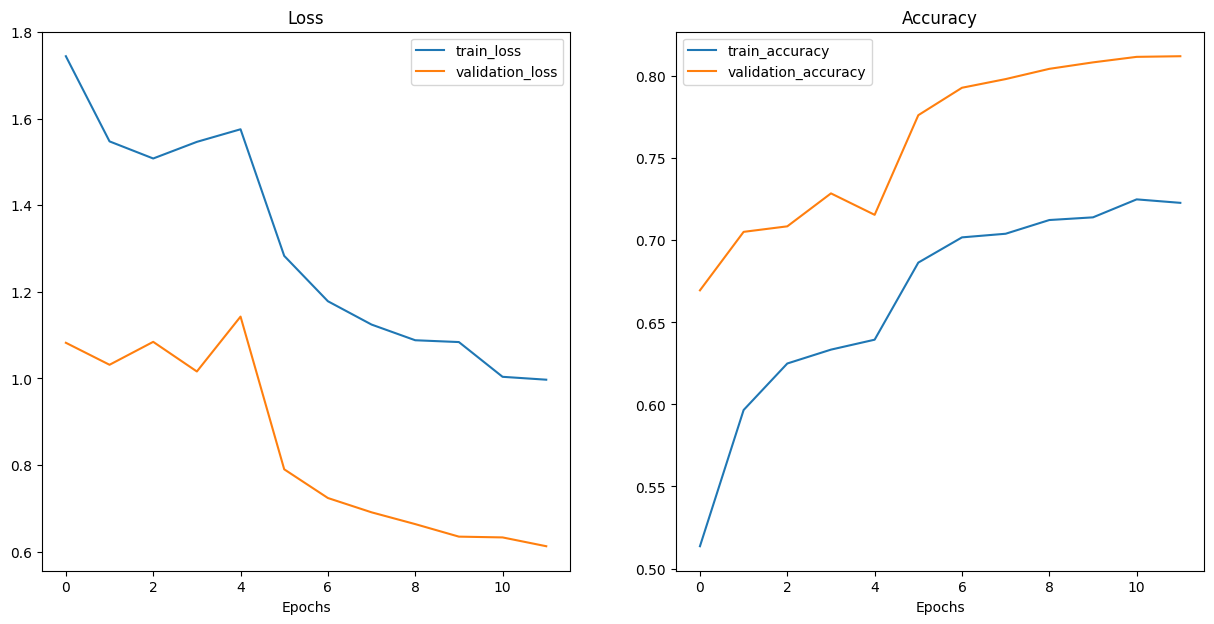

In [138]:
plot(model_train_val_perf)

### Define `infer()` function

In [140]:
def infer(ip_tensor: torch.Tensor, model: Module, transforms):

  input_tensors_for_inference = ip_tensor.cuda()
  transformed_input_tensors   = transforms(input_tensors_for_inference)

  p = model(transformed_input_tensors)

  inferred_labels = [torch.argmax(p[i]) for i in range(p.shape[0])]

  return inferred_labels


In [141]:
for _batch_data, _batch_labels in val_dl:

  res = infer(_batch_data.cuda() , model_custom, data_transforms)
  sum_matches = 0

  for i in range(len(res)):
    _inferred_label = res[i]
    _batch_label    = _batch_labels[i]

    print(f'Sample #{i}, inferred label: {_inferred_label}, validation label: {_batch_label}')

    if _inferred_label == _batch_label:
      sum_matches += 1

  print(f'Accuracy for this batch of data is: {sum_matches / p.shape[0]}')

  break

Sample #0, inferred label: 8, validation label: 8
Sample #1, inferred label: 3, validation label: 3
Sample #2, inferred label: 3, validation label: 3
Sample #3, inferred label: 3, validation label: 3
Sample #4, inferred label: 7, validation label: 7
Sample #5, inferred label: 1, validation label: 1
Sample #6, inferred label: 8, validation label: 8
Sample #7, inferred label: 9, validation label: 9
Sample #8, inferred label: 7, validation label: 8
Sample #9, inferred label: 3, validation label: 3
Sample #10, inferred label: 2, validation label: 5
Sample #11, inferred label: 3, validation label: 9
Sample #12, inferred label: 8, validation label: 8
Sample #13, inferred label: 2, validation label: 3
Sample #14, inferred label: 3, validation label: 3
Sample #15, inferred label: 5, validation label: 7
Sample #16, inferred label: 2, validation label: 8
Sample #17, inferred label: 6, validation label: 6
Sample #18, inferred label: 5, validation label: 5
Sample #19, inferred label: 7, validation

## Step 2 - Fit a more more complex model `convnext_small`

### Import pre-trained model for fine-tuning

In [181]:
from torchvision.models import *

# model2 = get_model("convnext_small", weights="IMAGENET1K_V1")

model2 = models.convnext_large(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Large_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [182]:
torchinfo.summary(model2,
                  input_size=(5, 3, 128, 128),
                  verbose=0,
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"]
                ) # What the pre-trained model looks like

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [5, 3, 128, 128]     [5, 1000]            --                   True
├─Sequential (features)                                 [5, 3, 128, 128]     [5, 1536, 4, 4]      --                   True
│    └─Conv2dNormActivation (0)                         [5, 3, 128, 128]     [5, 192, 32, 32]     --                   True
│    │    └─Conv2d (0)                                  [5, 3, 128, 128]     [5, 192, 32, 32]     9,408                True
│    │    └─LayerNorm2d (1)                             [5, 192, 32, 32]     [5, 192, 32, 32]     384                  True
│    └─Sequential (1)                                   [5, 192, 32, 32]     [5, 192, 32, 32]     --                   True
│    │    └─CNBlock (0)                                 [5, 192, 32, 32]     [5, 192, 32, 32]     306,048              True
│  

### Freeze all weights and update the FC layer

In [183]:
for param in model2.parameters():
    param.requires_grad = False

num_input_features_to_final_fully_connected_layer = model2.classifier[2].in_features
num_output_classes = len(train_ds.dataset.classes)

model2.classifier[2] = nn.Linear(
                                  in_features=num_input_features_to_final_fully_connected_layer,
                                  out_features=num_output_classes,
                                  device=device
                              )

model2 = model2.to(device)
criterion2 = nn.CrossEntropyLoss()

optimizer2 = optim.Adam(model2.classifier[2].parameters(), lr=0.01)
exp_lr_scheduler2 = lr_scheduler.StepLR(optimizer2, step_size=5, gamma=0.1)

torchinfo.summary(model2,
                  input_size=(5, 3, 128, 128),
                  verbose=0,
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"]
                ) # What the pre-trained model looks like

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [5, 3, 128, 128]     [5, 10]              --                   Partial
├─Sequential (features)                                 [5, 3, 128, 128]     [5, 1536, 4, 4]      --                   False
│    └─Conv2dNormActivation (0)                         [5, 3, 128, 128]     [5, 192, 32, 32]     --                   False
│    │    └─Conv2d (0)                                  [5, 3, 128, 128]     [5, 192, 32, 32]     (9,408)              False
│    │    └─LayerNorm2d (1)                             [5, 192, 32, 32]     [5, 192, 32, 32]     (384)                False
│    └─Sequential (1)                                   [5, 192, 32, 32]     [5, 192, 32, 32]     --                   False
│    │    └─CNBlock (0)                                 [5, 192, 32, 32]     [5, 192, 32, 32]     (306,048)            

### Train the `convnext` model

In [184]:
num_epochs2 = 6
model2_custom_, model2_results = train_model(
                                    _model=model2,
                                    dataloaders={'train': train_dl, 'val': val_dl},
                                    _criterion=criterion2,
                                    _optimizer=optimizer2,
                                    _scheduler=exp_lr_scheduler2,
                                    _num_epochs=num_epochs2
                                  )

Epoch 0/5
----------
train Loss: 1.3165 Acc: 0.5571 Time elap: 2m 26s LR: [0.01]
val Loss: 0.9567 Acc: 0.6836 Time elap: 2m 22s LR: [0.01]

Epoch 1/5
----------
train Loss: 1.0410 Acc: 0.6397 Time elap: 2m 24s LR: [0.01]
val Loss: 0.9067 Acc: 0.6968 Time elap: 2m 22s LR: [0.01]

Epoch 2/5
----------
train Loss: 0.9691 Acc: 0.6720 Time elap: 2m 24s LR: [0.01]
val Loss: 0.8161 Acc: 0.7173 Time elap: 2m 25s LR: [0.01]

Epoch 3/5
----------
train Loss: 0.9156 Acc: 0.6940 Time elap: 2m 24s LR: [0.01]
val Loss: 0.6765 Acc: 0.7756 Time elap: 2m 24s LR: [0.01]

Epoch 4/5
----------
train Loss: 0.8896 Acc: 0.7064 Time elap: 2m 24s LR: [0.001]
val Loss: 0.6705 Acc: 0.7779 Time elap: 2m 22s LR: [0.001]

Epoch 5/5
----------
train Loss: 0.7688 Acc: 0.7448 Time elap: 2m 24s LR: [0.001]
val Loss: 0.5672 Acc: 0.8168 Time elap: 2m 22s LR: [0.001]

Training complete in 29m 49s
Best val Acc: 0.816758


### Accuracy/Loss chart

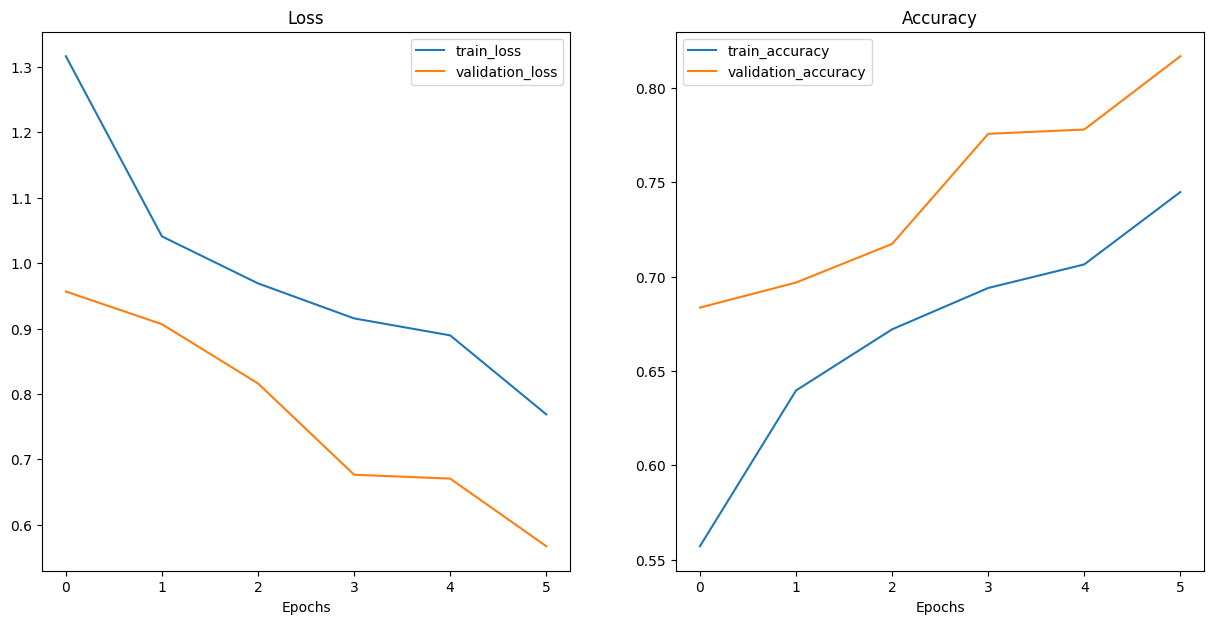

In [193]:
plot(model2_results)
# model2_results

## Step 3 - TTA (Test-time Augmentation) on the validation dataset

### Define `fit_with_tta` function

Is this the right way to go?

In [ ]:
def train_model_with_tta(model: nn.Module, dataloaders: dict, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    results: dict = {
            'train': {
                'acc_history': [],
                'loss_history': []
            },
            'val': {
                'acc_history': [],
                'loss_history': []
            }
        }

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:

                epoch_phase_since = time.time()

                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataloaders[phase].dataset.__len__()
                epoch_acc = running_corrects.double() / dataloaders[phase].dataset.__len__()

                results[phase]['loss_history'].append(epoch_loss)
                results[phase]['acc_history'].append(epoch_acc.item())

                epoch_phase_elapsed = time.time() - epoch_phase_since

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Time elap: {epoch_phase_elapsed // 60:.0f}m {epoch_phase_elapsed % 60:.0f}s LR: {scheduler.get_last_lr()}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, results

In [ ]:
def infer_with_tta(ip_tensor: torch.Tensor, model: Module, transforms):

  input_tensors_for_inference = ip_tensor.cuda()
  transformed_input_tensors   = transforms(input_tensors_for_inference)

  p = model(transformed_input_tensors)

  torch.mean(p, 1, True)

  inferred_labels = [(p[i]) for i in range(p.shape[0])]

  return inferred_labels

In [139]:
transformed_input_tensors.shape

torch.Size([64, 3, 128, 128])

In [90]:
class MyLazyDataset(Dataset):
  def __init__(self, dataset, transform=None):
    self.dataset = dataset
    self.transform = transform

    self.sample_idx_of_data  = 0
    self.sample_idx_of_label = 1

  def __getitem__(self, index):
    if self.transform:
      x = self.transform(self.dataset[index][self.sample_idx_of_data])
    else:
      x = self.dataset[index][self.sample_idx_of_data]
    y = self.targets[index][self.sample_idx_of_label]
    return x, y

  def __len__(self):
    return len(self.dataset.__len__())


def generate_randomized_train_val_idxs(indices: list, val_split: float) -> tuple:
  from random import shuffle

  size_ds = len(indices)
  size_val_ds   = int(size_ds * val_split)
  size_train_ds = size_ds - size_val_ds

  randomized_ds_indices = list(range(size_ds))
  shuffle(randomized_ds_indices)

  train_idxs = randomized_ds_indices[0:size_train_ds]
  val_idxs   = randomized_ds_indices[size_train_ds:]

  return (train_idxs, val_idxs)

In [92]:
test_l = list(range(100))

(split_1_l, split_2_l) = generate_randomized_train_val_idxs(test_l.copy(), 0.6)

assert len(split_1_l) == 40
assert len(split_2_l) == 60

from functools import reduce
assert reduce(lambda x,y: x and y, [e in test_l  for e in split_1_l])
assert reduce(lambda x,y: x and y, [e in test_l  for e in split_2_l])

In [97]:
validation_data_transforms = transforms.Compose([
    transforms.Resize(size=(160, 160)), # resize all images to the same size - as 4 of them are not the same size
    transforms.RandomResizedCrop(size=(128, 128), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

train_val_ds_for_tta: ImageFolder = ImageFolder(
                                      root=os.path.join(path, 'train_images')
                                    )

val_split = 0.2
(train_idxs, val_idxs) = generate_randomized_train_val_idxs(list(range(size_ds)), val_split)


train_ds_with_tta = MyLazyDataset(
                    dataset=train_val_ds_for_tta,
                    transform=data_transforms
                  )

val_ds_with_tta = MyLazyDataset(
                    dataset=train_val_ds_for_tta,
                    transform=validation_data_transforms
                  )

assert train_ds_with_tta.transform == train_ds.dataset.transform

print(train_ds_with_tta.transform)
print(train_ds.dataset.transform)
print(val_ds_with_tta.transform)

train_dl_with_tta: DataLoader = DataLoader(
                                            Subset(train_ds_with_tta, train_idxs),
                                            batch_size=64, shuffle=True
                                          )
val_dl_with_tta: DataLoader = DataLoader(
                                          Subset(val_ds_with_tta, val_idxs),
                                          batch_size=64, shuffle=True
                                        )

# print(f'Splitting dataset of size {size_ds} into train set of size {size_train_ds} and val set of size {size_val_ds}')

# train_ds, val_ds = torch.utils.data.random_split(train_val_ds, [size_train_ds, size_val_ds])

# train_ds and val_ds are of type Subset(dataset, indices)
#   * if you do train_ds.dataset you get the full ImageFolder dataset back
#   * if you do train_ds.indices you get the indices of the full dataset used to make the train ds

# train_dl = DataLoader(train_ds.dataset, batch_size=64, shuffle=True)
# val_dl = DataLoader(val_ds.dataset, batch_size=64, shuffle=True)

Compose(
      Resize(size=[480, 480], interpolation=InterpolationMode.BILINEAR, antialias=True)
      RandomResize(min_size=128, max_size=160, interpolation=InterpolationMode.BILINEAR, antialias=True)
      RandomCrop(size=(128, 128), pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
)
Compose(
      Resize(size=[480, 480], interpolation=InterpolationMode.BILINEAR, antialias=True)
      RandomResize(min_size=128, max_size=160, interpolation=InterpolationMode.BILINEAR, antialias=True)
      RandomCrop(size=(128, 128), pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
)
Compose(
      Resize(size=[160, 160], interpolation=InterpolationMode.BILINEAR, antialias=True)
      RandomResizedCrop(size=(128, 128), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias=True)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
)


## Step 3 - Next model `convnext_small`